In [3]:
%matplotlib inline

In [15]:
import matplotlib.pyplot as plt
import numpy

import screed
from collections import defaultdict

import importlib
import alignplot
import pprint
importlib.reload(alignplot)

from alignplot import StackedDotPlot

## another tara genome, this time with two contaminants

In [5]:
if 0:
    dotplot = StackedDotPlot('TARA_PSE_MAG_00132', ('GCA_001550135.1', 'GCA_001641615.1'), 'list.csv', './genomes')
    #dotplot.use_mashmap = True
    x = dotplot()

In [6]:
if 0:
    dotplot = StackedDotPlot('TARA_ANW_MAG_00083', ('GCA_002171995.1',), 'list.csv', './genomes')
    dotplot = StackedDotPlot('GCA_002171995.1', ('TARA_ANW_MAG_00083',), 'list.csv', './genomes')

    dotplot.use_mashmap = True
    x = dotplot()

In [7]:
if 0:
    dotplot = StackedDotPlot('GCA_001550135.1', ('TARA_PSE_MAG_00132', 'GCA_001641615.1'), 'list.csv', './genomes')
    #dotplot.use_mashmap = True
    x = dotplot()

['./genomes/GCA_003220225.1_ASM322022v1_genomic.fna']
found queryfile for GCA_003220225.1: ./genomes/GCA_003220225.1_ASM322022v1_genomic.fna
found targetfile for GCA_003222275.1: ./genomes/GCA_003222275.1_ASM322227v1_genomic.fna
running nucmer & show-coords for ./genomes/GCA_003222275.1_ASM322227v1_genomic.fna...
...done! reading output from /var/folders/y6/s1r3q87933s6gjdrtmts1npc0000gq/T/tmpmhom5fc_.
shared w/Acidobacteria bacterium: 635.4kb
['./genomes/GCA_003222275.1_ASM322227v1_genomic.fna']
found queryfile for GCA_003222275.1: ./genomes/GCA_003222275.1_ASM322227v1_genomic.fna
found targetfile for GCA_003220225.1: ./genomes/GCA_003220225.1_ASM322022v1_genomic.fna
running nucmer & show-coords for ./genomes/GCA_003220225.1_ASM322022v1_genomic.fna...
...done! reading output from /var/folders/y6/s1r3q87933s6gjdrtmts1npc0000gq/T/tmp_o8xxgd6.
shared w/Candidatus Rokubacteria bacterium: 640.9kb


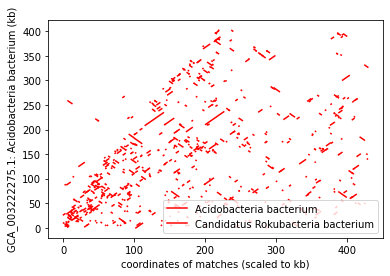

In [8]:
if 1:
    dotplot = StackedDotPlot('GCA_003220225.1',
                             ['GCA_003222275.1',],
                             'list.csv', './genomes')
    _ = dotplot()
    
if 1:
    dotplot2 = StackedDotPlot('GCA_003222275.1',
                             ['GCA_003220225.1'],
                             'list.csv', './genomes')
    _ = dotplot2()

In [9]:
#dotplot = StackedDotPlot('GCA_003222275.1',
#                         ['GCA_003222275.1',],
#                         'list.csv', './genomes')
#_ = dotplot()

## region response curve

underlying logic:

* for our primary use case here (contamination/legitimate "shared" nucleotides), we can consider nt alignments of >= 95% to be contamination to be removed
* we want to remove as many bp of contamination as possible with as little "legit" non-shared nt as possible.



In [23]:
def group_regions_by(regions, by_type):
    "gather regions by 'target' or 'query'"

    assert by_type in ('target', 'query')

    regions_by = defaultdict(list)
    for region in regions:
        name = getattr(region, by_type)
        x = regions_by[name]
        x.append(region)
        
    return regions_by

def region_size(region, by_type):
    assert by_type in ('target', 'query')
    
    if by_type == 'target':
        return abs(region.tend - region.tstart)
    elif by_type == 'query':
        return abs(region.qend - region.qstart)
    raise Exception(f'unhandled by_type {by_type}')
    

def load_contig_sizes(genomefile):
    "load in all the actual contig sizes for this genome (in kb)"
    all_sizes = {}
    for record in screed.open(genomefile): # @CTB
        all_sizes[record.name.split()[0]] = len(record.sequence) / 1e3
        
    return all_sizes

def investigate_target_regions(dotplot, t_acc):
    regions = dotplot.results[t_acc]

    # first, find the targetfile (genome) for this accession
    targetfile = dotplot.get_targetfile(t_acc)

    # next, set up to sort matches by overall contig ANI, and also track summed alignments >= 95% ANI
    sorted_regions = []
    kb_above_95 = 0
    for region in regions:
        size = region_size(region, 'target')
        pident = region.pident
        fident = pident / 100
        f_match =  size / region.tsize #@CTB
        contig_ani = f_match * fident
        sorted_regions.append((contig_ani, f_match, region))
        
        if pident >= 95:
            kb_above_95 += size

    # sort regions by estimated contig ANI, for removal. note, may be dups... @CTB
    sorted_regions.sort(reverse=True)
    
    regions_by_target = group_regions_by(regions, 'target')

    # load in all the actual contig sizes for this genome
    sum_bp = 0
    all_sizes = load_contig_sizes(targetfile)
    sum_bp = sum(all_sizes.values())

    # construct x, y.
    x = []
    y = []
    sofar = 0
    ani_sofar = 0
    seen = set()
    for (_, _, region) in sorted_regions:
        if region.target in seen:
            continue
            
        seen.add(region.target)
        for region2 in regions_by_target[region.target]:
            if region2.pident >= 95:
                ani_sofar += region_size(region, 'target')
        
        sofar += all_sizes[region.target]
        assert all_sizes[region.target] > 0
        x.append(sofar)
        y.append(ani_sofar)
        
    remaining_names = set(all_sizes) - seen
    for contig in remaining_names:
        sofar += all_sizes[contig]
        x.append(sofar)
        y.append(ani_sofar)
           
    return numpy.array(x), numpy.array(y)

t_acc = dotplot.t_acc_list[0]
x, y = investigate_target_regions(dotplot, t_acc)

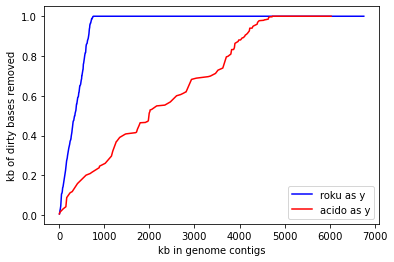

In [24]:
# worry about duplicate bad kb
t_acc = dotplot.t_acc_list[0]
x, y = investigate_target_regions(dotplot, t_acc)

t_acc = dotplot2.t_acc_list[0]
x2, y2 = investigate_target_regions(dotplot2, t_acc)

plt.plot(x, y / max(y), 'b-', label='roku as y')
plt.plot(x2, y2 / max(y2), 'r-', label='acido as y')

plt.xlabel('kb in genome contigs')
plt.ylabel('kb of dirty bases removed')
plt.legend(loc='lower right')
plt.savefig('/tmp/acido-target.png')